In [1]:
import sys
sys.path.append("..")
from core.DataLoader import DataPreprocessor, DataConfig, LoadConfig, get_load_config_from_yaml
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.regression_models as RegressionModels
import core.assignment_models as AssignmentModels
import core
import keras
plt.rcParams["font.size"] = 14

PLOTS_DIR = f"plots/regresion_transformer/"
MODEL_DIR  = f"models/regresion_transformer/"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)


load_config = get_load_config_from_yaml("workspace_config.yaml")

DataProcessor = DataPreprocessor(load_config)

data_config_path = "workspace_config.yaml"
with open(data_config_path, "r") as file:
    data_configs = yaml.safe_load(file)

data_config = DataProcessor.load_data(
    data_configs["data_path"]["nominal"], "reco", max_events=100000
)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.1)

2025-11-07 15:00:01.627738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 15:00:01.628520: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-07 15:00:01.632126: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-07 15:00:01.641083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762524001.654801 1275493 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762524001.65

Removed 313 events with negative weights


In [2]:
AssignmentTransformer = AssignmentModels.FeatureConcatTransformer(data_config, name=r"Assignment Transformer + $\nu$-Flows")
AssignmentTransformer.load_model(MODEL_DIR+ "model.keras")

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.


2025-11-07 15:00:20.888102: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model loaded from models/regresion_transformer/model.keras


In [3]:
RegressionTransformer = RegressionModels.FeatureConcatTransformer(data_config, name="Regression Transformer")
RegressionTransformer.load_model(MODEL_DIR+ "model.keras")

Model loaded from models/regresion_transformer/model.keras


In [4]:
import core.assignment_models.BaselineAssignmentMethods as BaselineMethods
import core.reconstruction as Evaluation

reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(
    data_config
)
chi_square_true_nu = BaselineMethods.MassCombinatoricsAssigner(
    data_config,
    top_mass=173.5e3,
)
ground_truth_assigner = Evaluation.GroundTruthReconstructor(data_config, name = "Perfect Reconstructor")
evaluator = Evaluation.ReconstructionEvaluator(
    [
        chi_square_true_nu,
        RegressionTransformer,
        AssignmentTransformer,
        ground_truth_assigner,
    ],
    X_val,
    y_val,
)

Defaulting to 'nu_flows_regression_targets' for neutrino reconstruction.


2025-11-07 15:00:24.224528: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.



Computing bootstrap confidence intervals...
$\chi^2$-Method($\nu^2$-Flows): 0.6148 [0.6054, 0.6240]
Regression Transformer: 0.7969 [0.7890, 0.8049]
Assignment Transformer + $\nu$-Flows: 0.7969 [0.7888, 0.8040]
Perfect Reconstructor: Ground Truth (skipping)


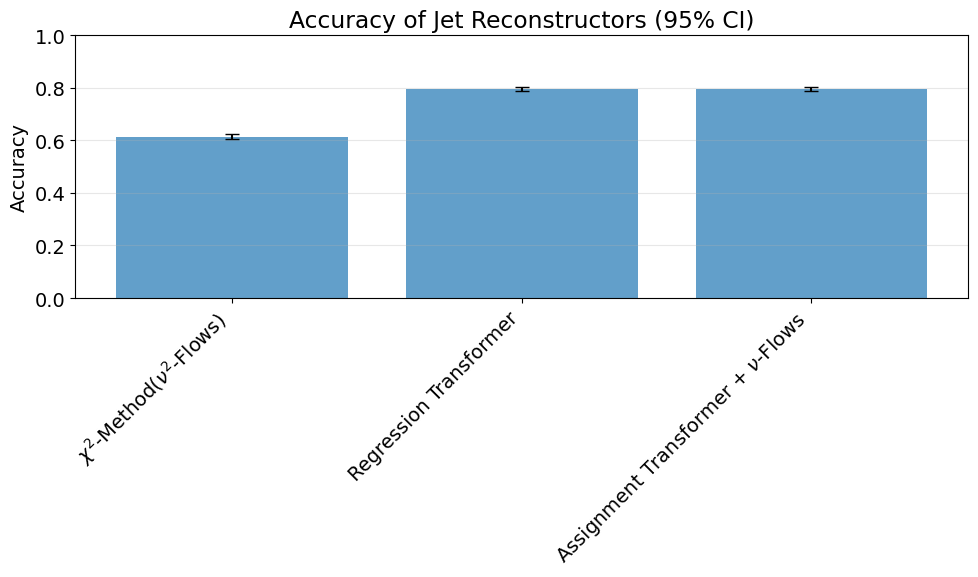

In [5]:
fig, ax = evaluator.plot_all_accuracies()
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing binned top mass resolution for truth_ttbar_mass...


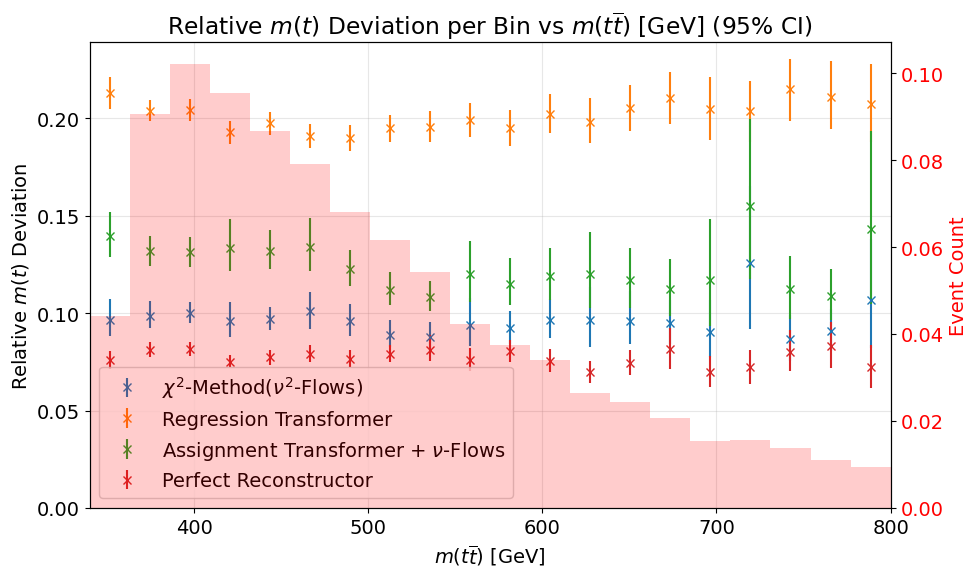

In [6]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")


Computing binned ttbar mass resolution for truth_ttbar_mass...


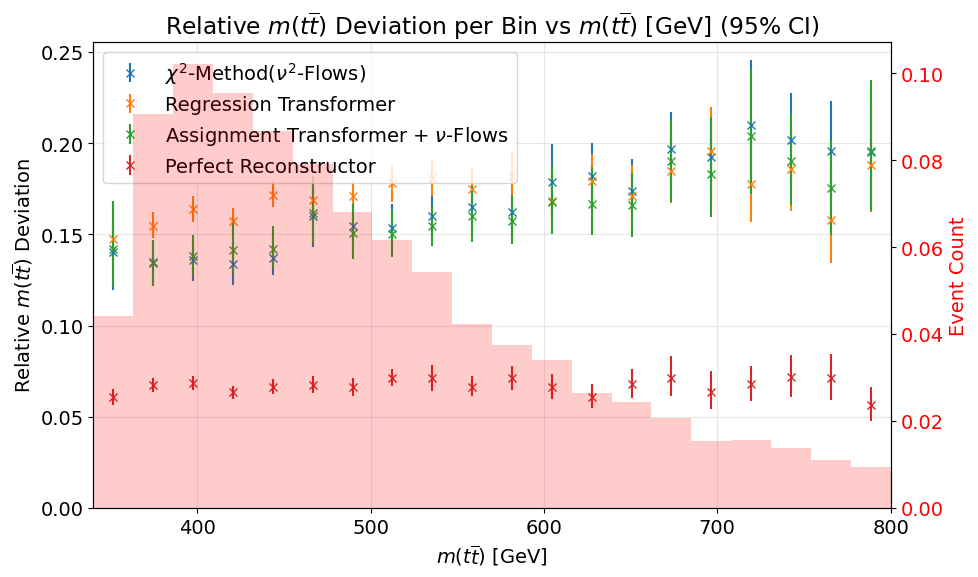

In [7]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing binned complementarity for truth_ttbar_mass...


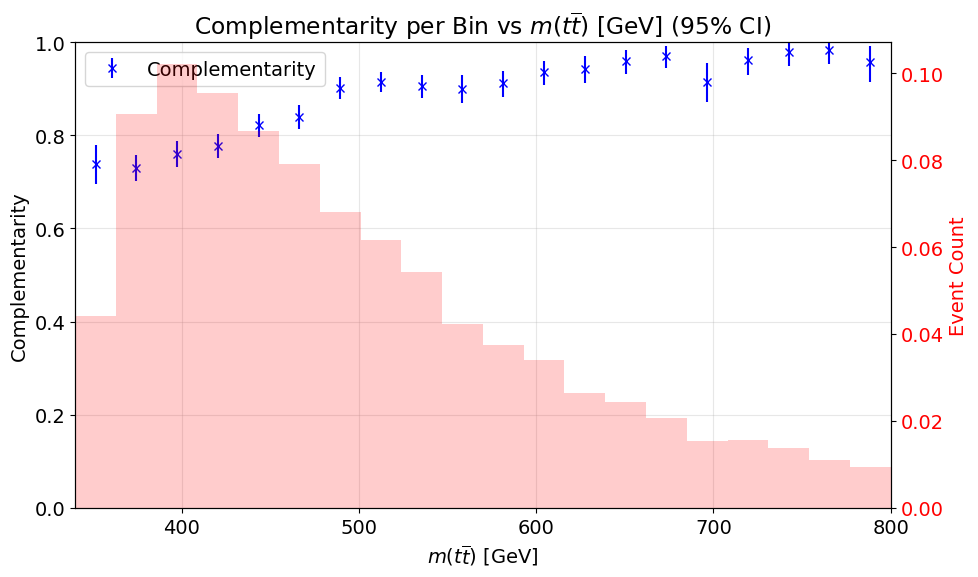

In [8]:
fig, ax = evaluator.plot_binned_complementarity(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)

fig.savefig(PLOTS_DIR + "binned_complementarity_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_mass...


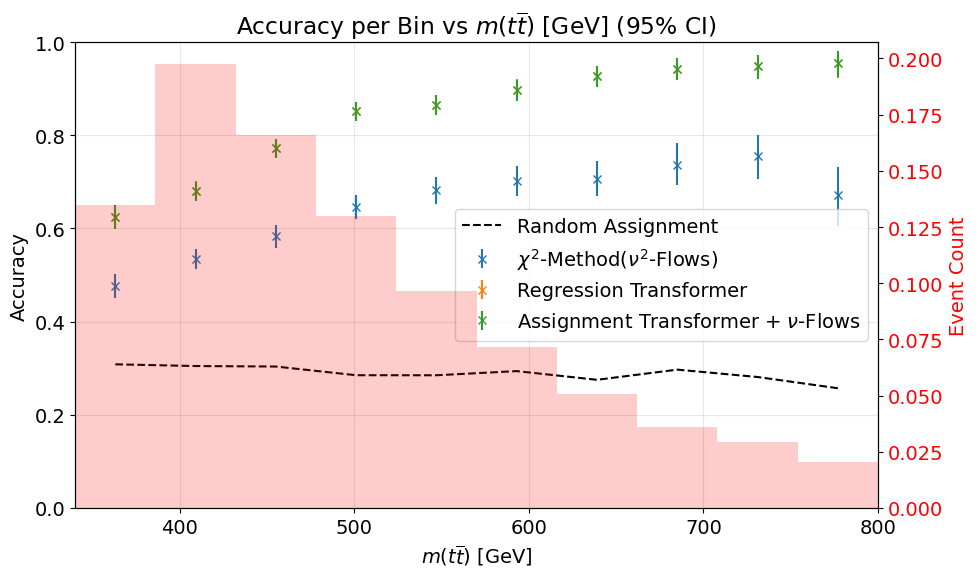

In [9]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=(340e3, 800e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 800e3)
fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_mass.pdf")


Computing binned accuracy for truth_ttbar_pt...


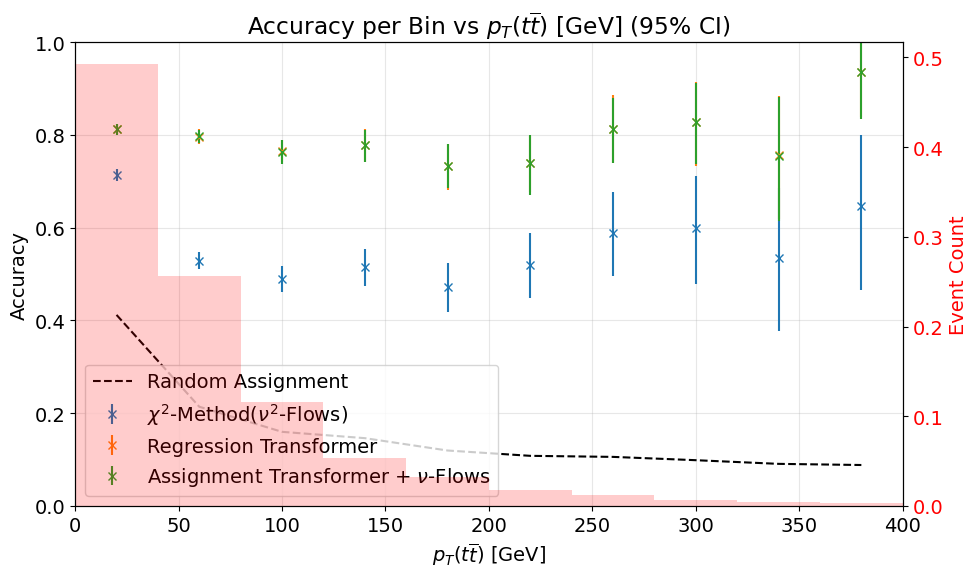

In [10]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_ttbar_pt",
    fancy_feature_label=r"$p_T(t\overline{t})$ [GeV]",
    xlims=(0, 400e3),
    bins=10,
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(0, 400e3)

fig.savefig(PLOTS_DIR + "binned_accuracy_ttbar_pT.pdf")


Computing binned accuracy for truth_initial_parton_num_gluons...


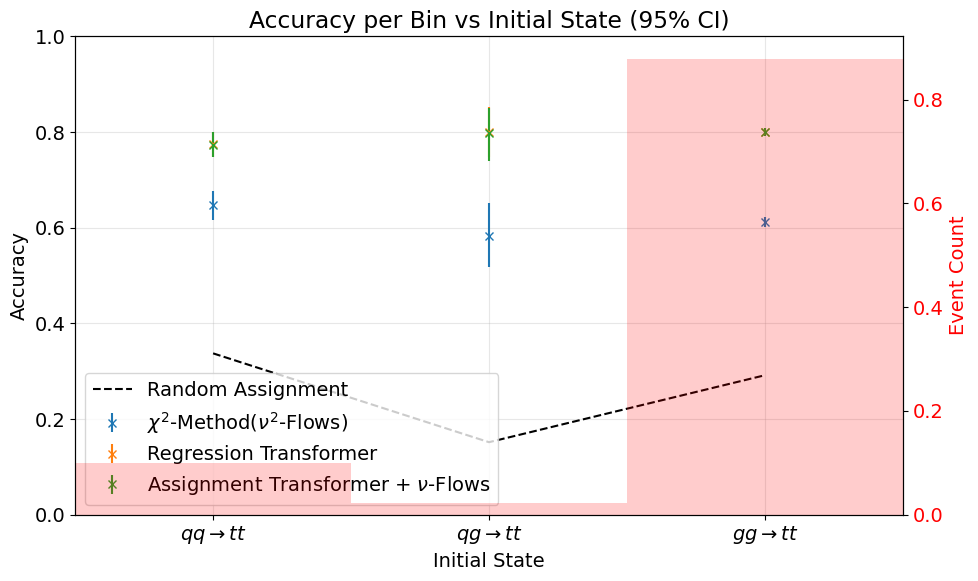

In [11]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="truth_initial_parton_num_gluons",
    fancy_feature_label=r"Initial State",
    xlims=(0, 3),
    bins=3,
)
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels([r"$qq\to tt$", r"$qg\to tt$", r"$gg\to tt$"])
fig.savefig(PLOTS_DIR + "binned_accuracy_initial_state.pdf")


Computing binned accuracy for N_jets...


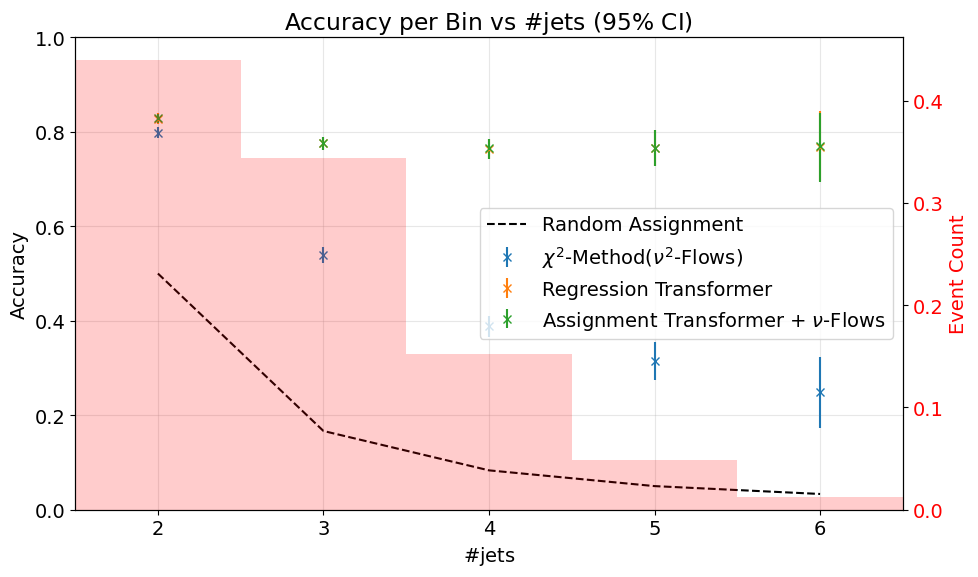

In [12]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_configs["LoadConfig"]["max_jets"] + 1),
    bins= data_configs["LoadConfig"]["max_jets"] -1,
)
ax.set_xticks([i + 0.5 for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
ax.set_xticklabels([i for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

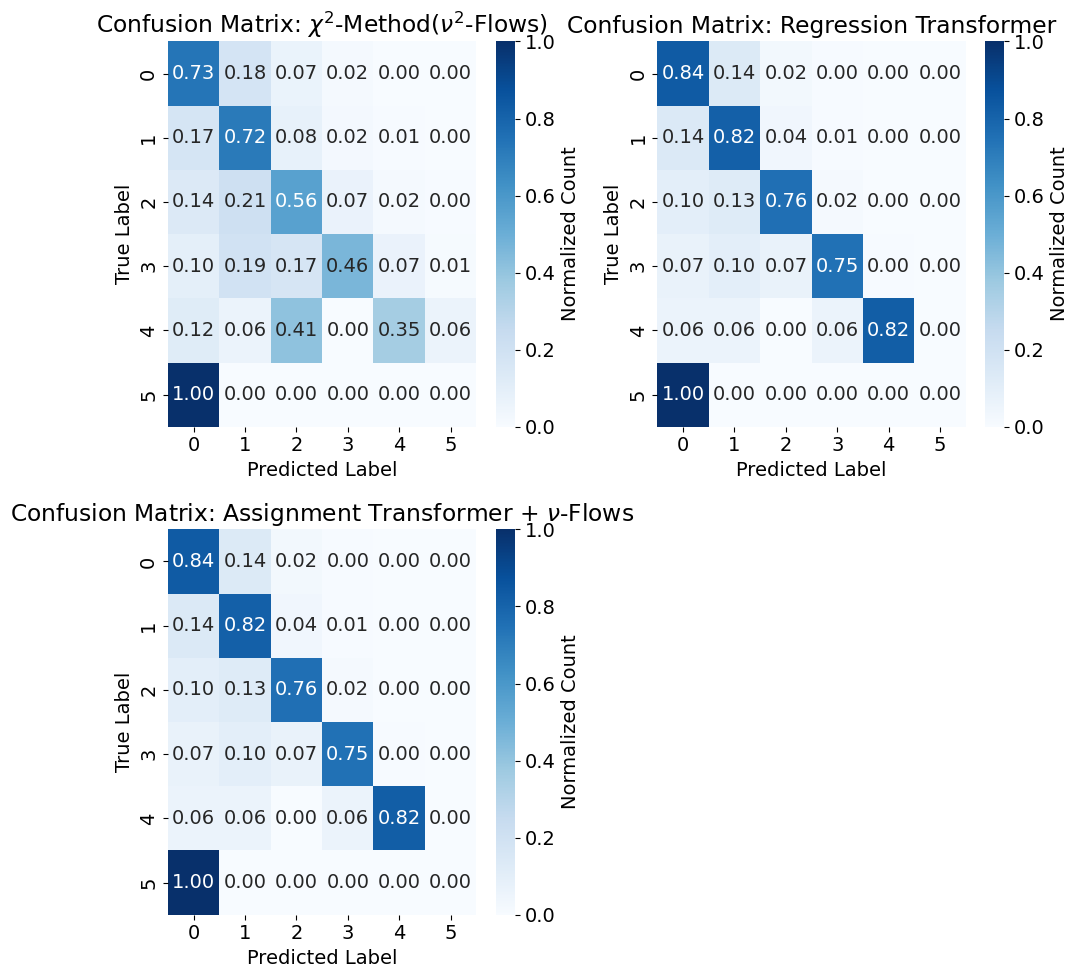

In [13]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

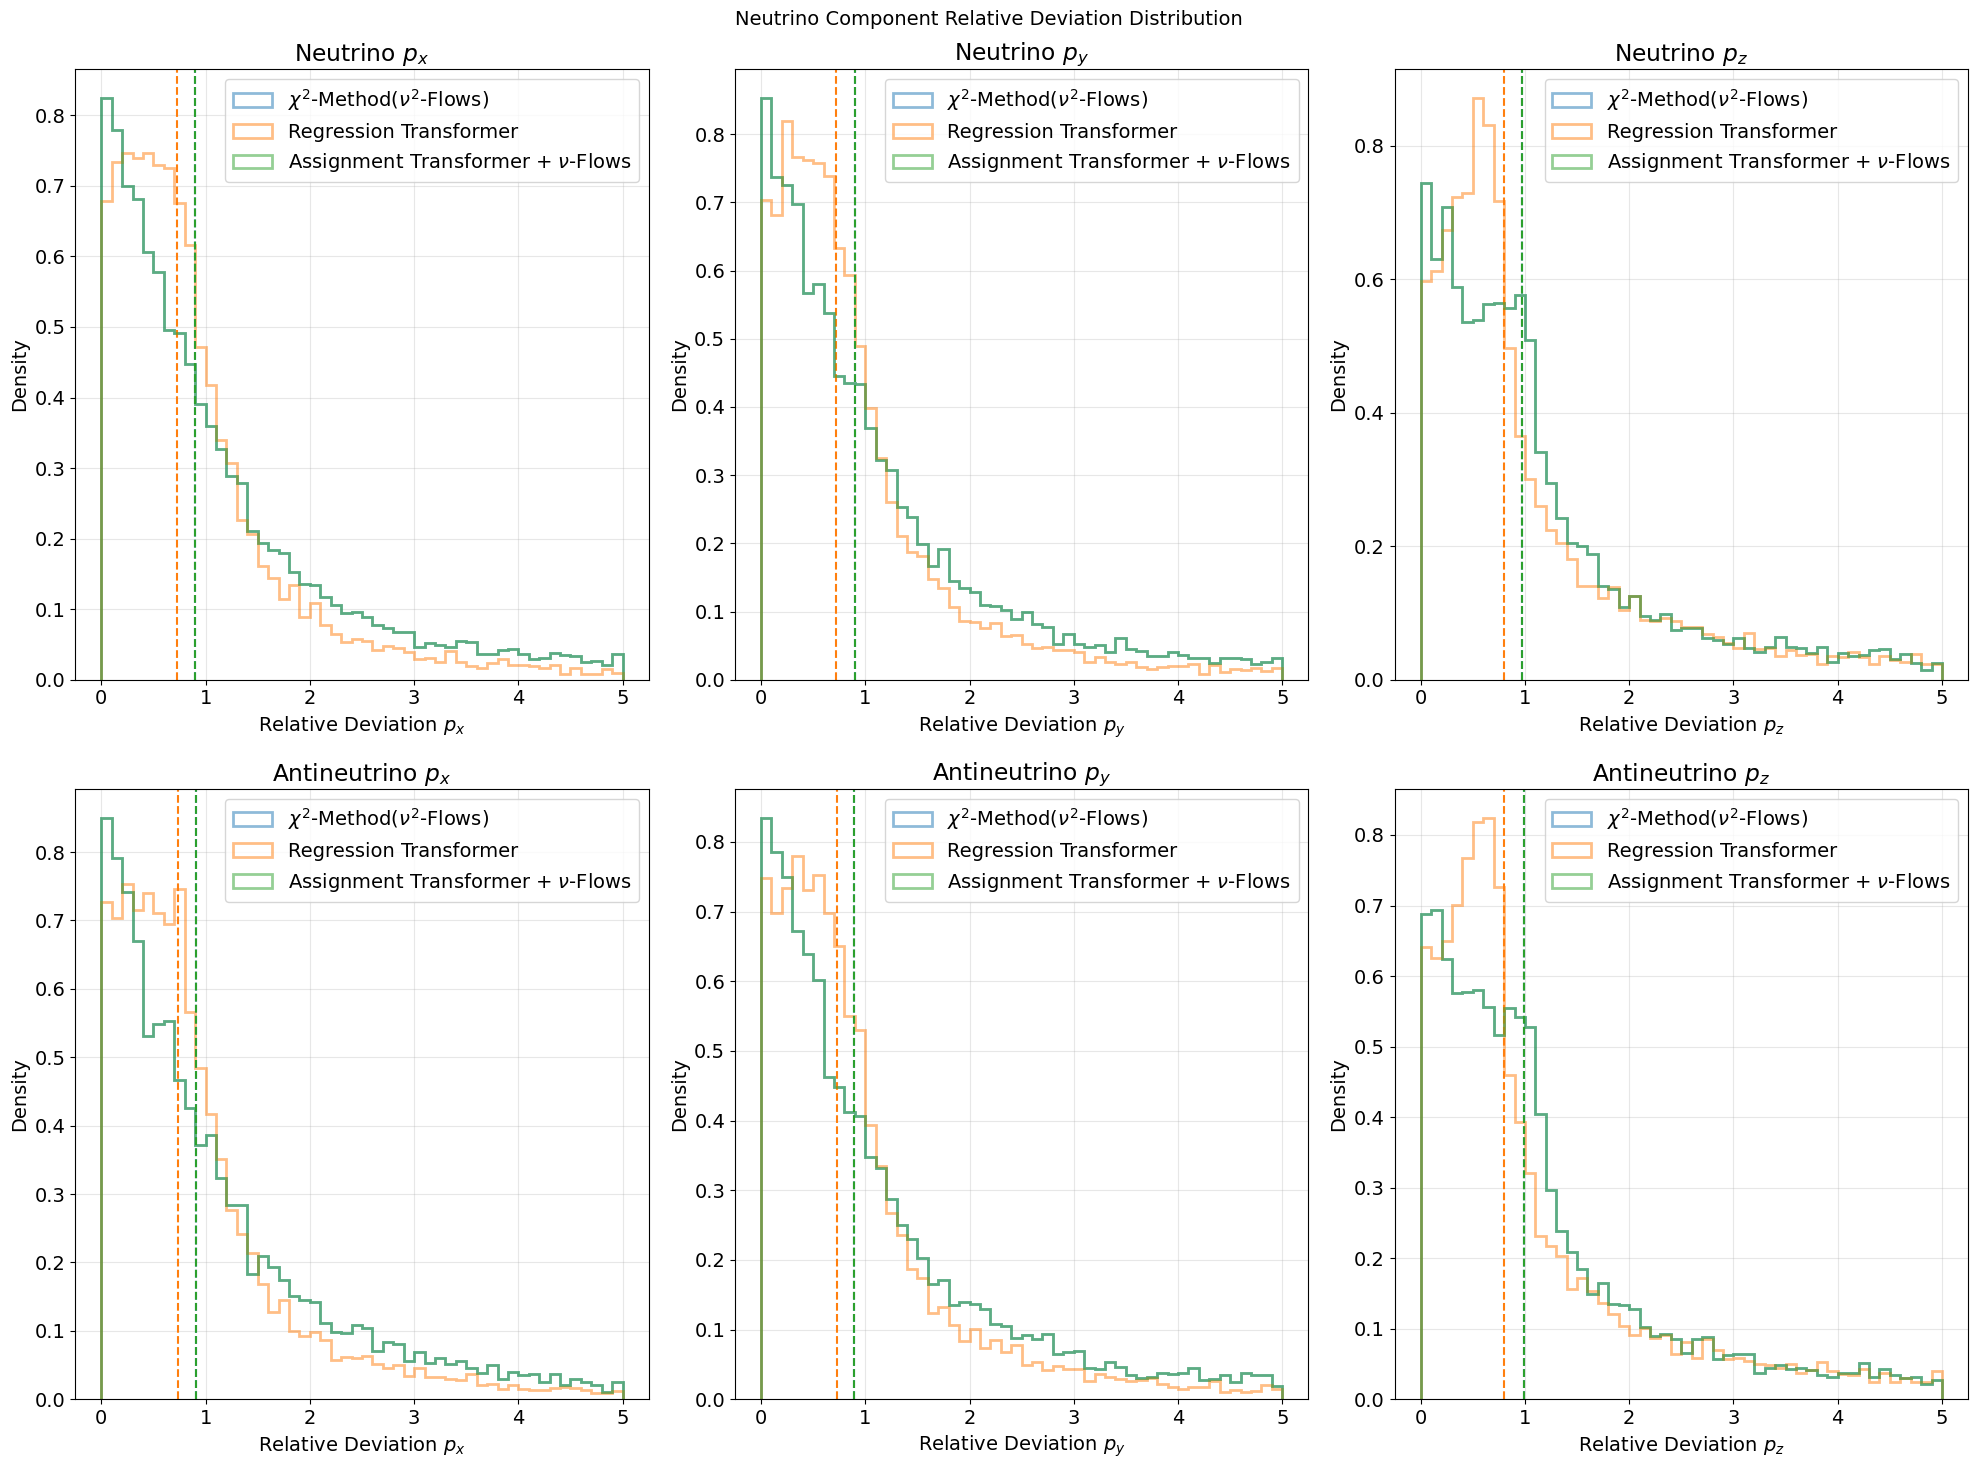

In [14]:
# Plot neutrino component deviation histograms
fig, axes = evaluator.plot_neutrino_component_deviations(
    bins=50,
    xlims=(0, 5),  # Optional: limit x-axis range
    figsize=(20, 15),
    component_labels=["$p_x$", "$p_y$", "$p_z$"]
)


Computing bootstrap confidence intervals for neutrino deviation...
$\chi^2$-Method($\nu^2$-Flows): 1.6004 [1.5618, 1.6422]
Regression Transformer: 1.1622 [1.1409, 1.1841]
Assignment Transformer + $\nu$-Flows: 1.6012 [1.5604, 1.6428]
Perfect Reconstructor: Ground Truth (skipping)
Perfect Reconstructor: 0.0000 [0.0000, 0.0000]


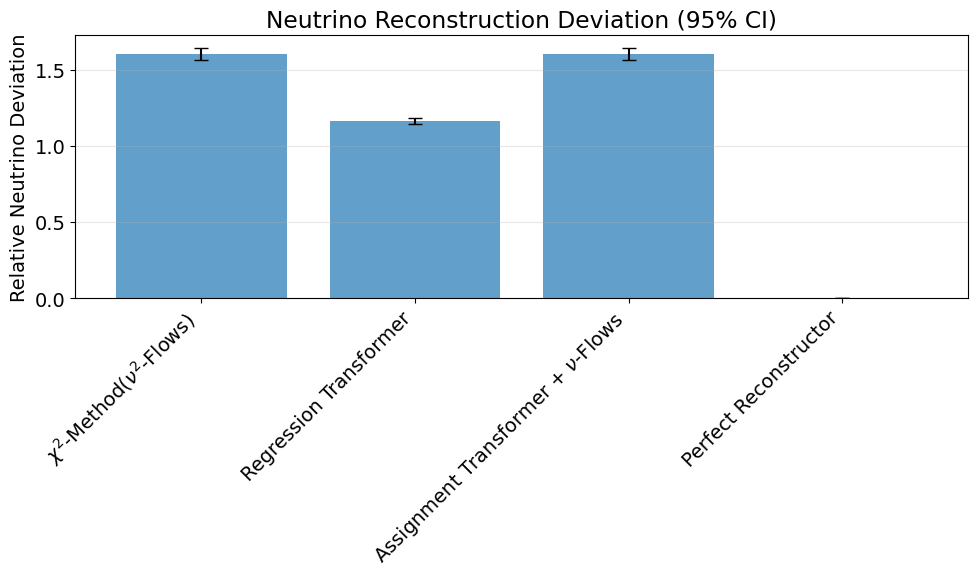

In [15]:
# Plot overall relative deviation distribution
fig, ax = evaluator.plot_all_neutrino_deviations()